# Exploratory Data Analysis (EDA)

#### Preparing Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/data.csv")

#### Overview of the Data

In [ ]:
# Shape of the dataset
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Preview of first few rows
df.head()

# Data types and non-null counts
df.info()

Rows: 95662, Columns: 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  

#### Summary Statistics

In [ ]:
# Summary statistics for numerical columns
df.describe()

# Unique counts for categorical columns
df.select_dtypes(include=['object']).nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
TransactionStartTime    94556
dtype: int64

#### Distribution of Numerical Features

To better visualize the distribution of typical transaction amounts, I clip the range at 500,000 UGX.
This helps isolate the dense region of the data and allows me to explore the most frequent transaction values,
without being distorted by extreme outliers in the tail.


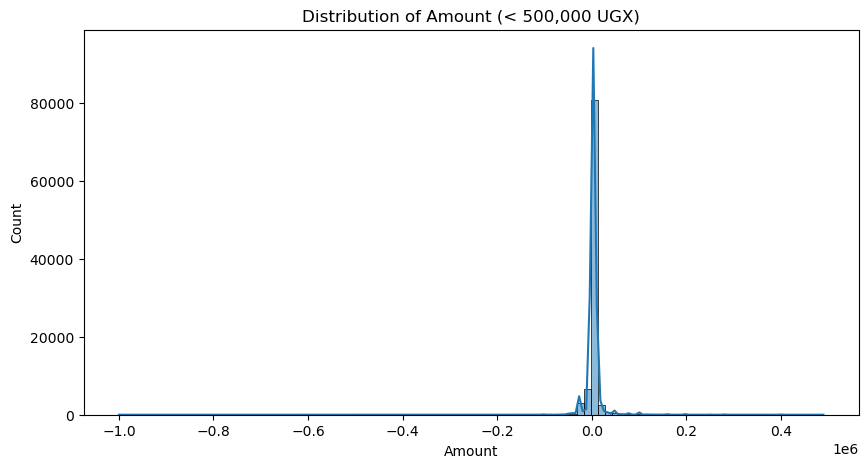

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df['Amount'] < 500000]['Amount'], bins=100, kde=True)
plt.title("Distribution of Amount (< 500,000 UGX)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()


The 'Amount' feature is highly right-skewed due to a long tail of large transactions.
Applying a log transformation (log1p) helps compress the scale, normalize the distribution,
and reveal patterns in the lower range of transaction values which dominate the data.


c:\Users\user\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


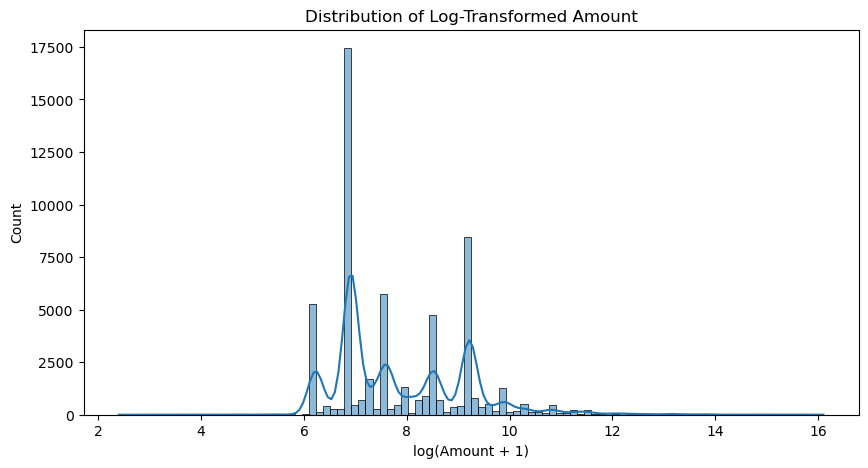

In [ ]:
# Adding 1 to avoid log(0)
df['log_amount'] = np.log1p(df['Amount'])

plt.figure(figsize=(10, 5))
sns.histplot(df['log_amount'], bins=100, kde=True)
plt.title("Distribution of Log-Transformed Amount")
plt.xlabel("log(Amount + 1)")
plt.ylabel("Count")
plt.show()


#### Distribution of Categorical Features

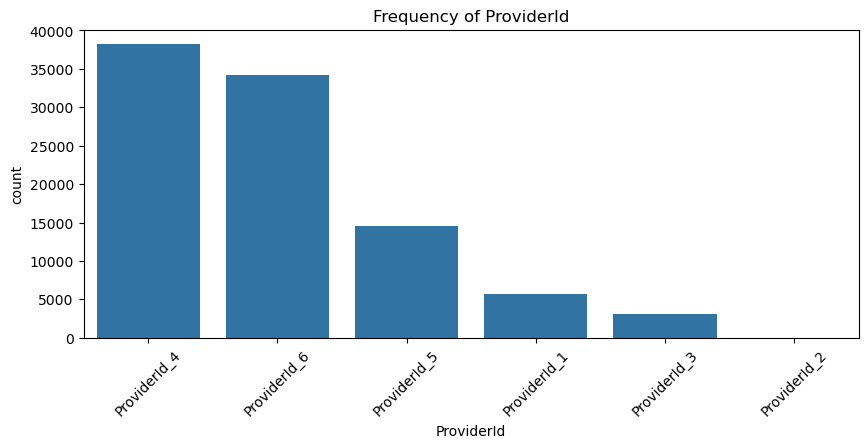

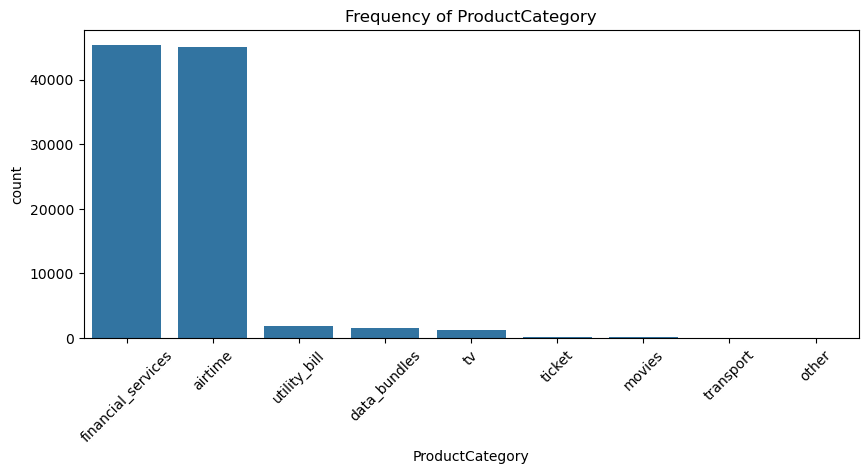

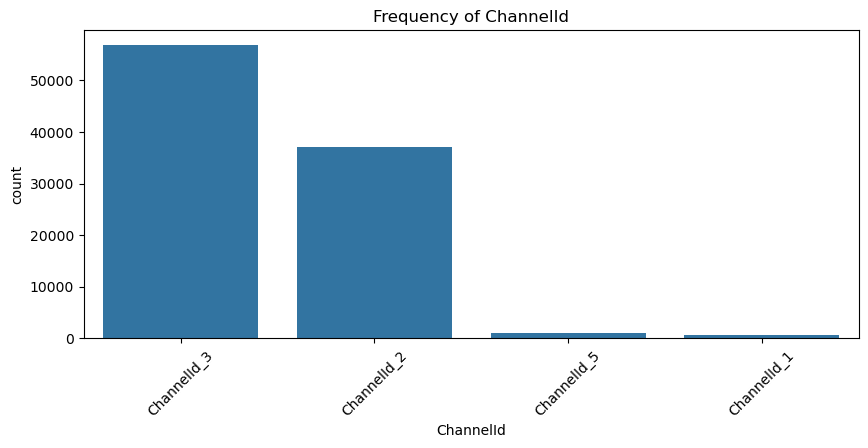

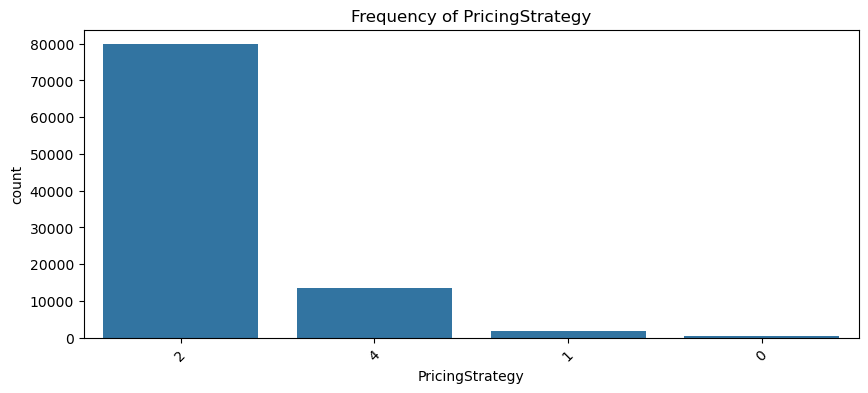

In [14]:
categorical_cols = ['ProviderId', 'ProductCategory', 'ChannelId', 'PricingStrategy']

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().iloc[:10].index)
    plt.xticks(rotation=45)
    plt.title(f'Frequency of {col}')
    plt.show()


#### Correlation Analysis

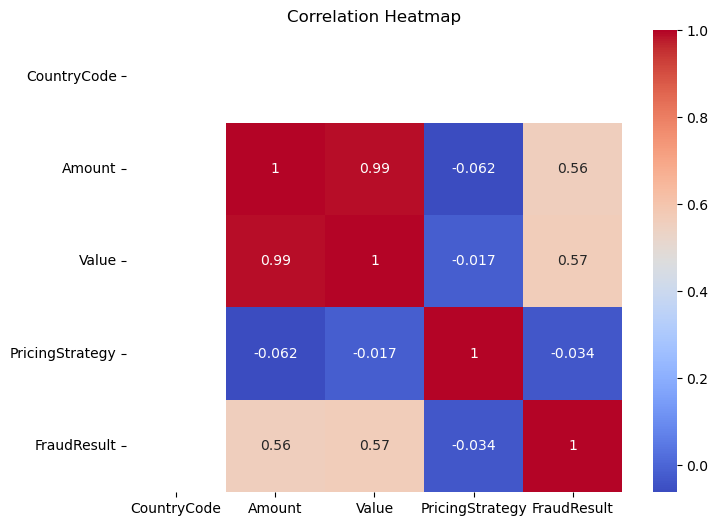

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

#### Missing Values

In [9]:
# Total and percentage of missing values
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)

,Missing Values,Percent


#### Outlier Detection

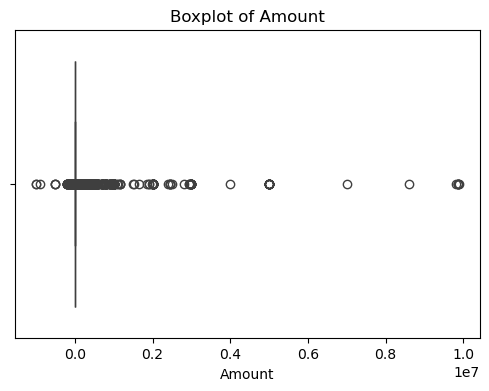

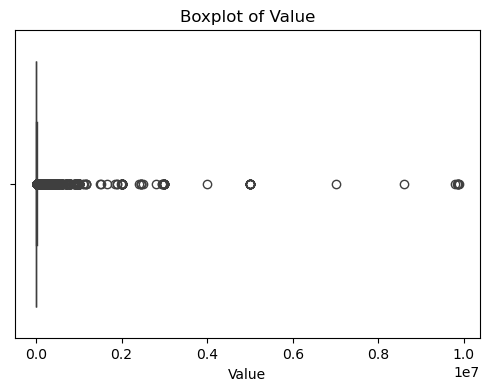

In [10]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

## Top EDA Insights for Credit Risk Modeling

### 1. FraudResult is Moderately Correlated with Amount and Value
- **Correlation with FraudResult:**
  - Amount: 0.56
  - Value: 0.57  
- These strong positive correlations suggest that higher transaction amounts are more likely to be fraudulent, making these features highly relevant for risk prediction.

### 2. Amount and Value are Nearly Identical
- **Correlation between Amount and Value: 0.99**
- Indicates redundancy — only one of these should be retained during modeling to avoid multicollinearity and simplify the feature set.

### 3. CurrencyCode and CountryCode Have No Variability
- All records share the same values:
  - CurrencyCode: UGX
  - CountryCode: 256  
- These features lack informational value and should be excluded from model training.

### 4. Strong Class Imbalance & High-Frequency Categorical Values
- Features like `ProviderId`, `ProductCategory`, and `ChannelId` are highly imbalanced:
  - Dominant classes include ProviderId_4, ChannelId_3, and ProductCategory types like airtime and financial services.
- May cause modeling bias. Consider:
  - Frequency or target encoding
  - Stratified sampling during model training

### 5. Severe Outliers in Transaction Amounts
- Most transactions fall within 0–200,000 UGX, but a few exceed 10 million UGX.
- outliers distort visualizations addressed using:
  - Log transformation for normalization
  - Clipped Range Plot

### 6. PricingStrategy Distribution is Highly Skewed
- PricingStrategy 2 dominates, while 0 is least used.
- May indicate default vs. special-use cases.
- Keep as a categorical feature, but handle imbalance with care during training.

### 7. No Missing Values in Numerical Columns
- Fields like Amount, Value, PricingStrategy, and FraudResult contain **no missing values**.
- No imputation needed — enables a streamlined modeling pipeline.
